# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [56]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 116000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (116000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [57]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [58]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(100551, 10)

In [59]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

86.68189655172414

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [60]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [61]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(100549, 10)


1    84354
0    16195
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [11]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [9]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [62]:
# Combining all the above stundents 
from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|█████████████████████████████████| 100549/100549 [01:57<00:00, 852.71it/s]


In [13]:
preprocessed_reviews[1500]

'not happy product cooked potatoes flat not look thing like product picture seen shipping cost much potatoes'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [67]:
## Similartly you can do preprocessing for review summary also.
# Splitting our input into Test and Train 
from sklearn.model_selection import TimeSeriesSplit
Y=final['Score']

y_train=Y[:70384]
y_test=Y[70384:]

print(y_train.shape)
print(y_test.shape)

X_train=preprocessed_reviews[:70384]
X_test=preprocessed_reviews[70384:]



(70384,)
(30165,)


# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [42]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [36]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [38]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [39]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [41]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [68]:
# Please write all the code with proper documentation
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)
bow_fnames=count_vect.get_feature_names()
final_counts_train = count_vect.transform(X_train)
print("the type of count vectorizer ",type(final_counts_train))
print("the shape of out text BOW vectorizer ",final_counts_train.get_shape())
print("the number of unique words ", final_counts_train.get_shape()[1])

final_counts_test = count_vect.transform(X_test)
print("the type of count vectorizer ",type(final_counts_test))
print("the shape of out text BOW vectorizer ",final_counts_test.get_shape())
print("the number of unique words ", final_counts_test.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (70384, 49158)
the number of unique words  49158
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (30165, 49158)
the number of unique words  49158


In [69]:
# Standardsing features using preprocessing algorithm
from sklearn import preprocessing
from sklearn.preprocessing import MaxAbsScaler
pre_mod=MaxAbsScaler().fit(final_counts_train)
std_bow_train=pre_mod.transform(final_counts_train)
std_bow_test=pre_mod.transform(final_counts_test)
print(std_bow_train.shape,'\n',std_bow_test.shape)

(70384, 49158) 
 (30165, 49158)


In [70]:
from sklearn.linear_model import SGDClassifier
from prettytable import PrettyTable
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score,average_precision_score,roc_auc_score,auc

lr=SGDClassifier(loss='hinge',random_state=42,n_jobs=-1,class_weight='balanced')
parameter={'alpha':[0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0,10000.0],'penalty':['l1','l2']}
tss=TimeSeriesSplit(n_splits=5).split(std_bow_train)
score=make_scorer(roc_auc_score,average='weighted')

gscv=GridSearchCV(estimator=lr,scoring=score,cv=tss,param_grid=parameter,verbose=1)

gscv.fit(std_bow_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   22.5s finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000000011B02CA8>,
       error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(roc_auc_score, average=weighted), verbose=1)

In [71]:
#Caliberate the classifier.
from sklearn.calibration import CalibratedClassifierCV
clf_calibrated=CalibratedClassifierCV(gscv,cv="prefit", method="isotonic")
clf_calibrated.fit(std_bow_train, y_train)
print("mean accuracy on the given test data and labels = ",clf_calibrated.score(std_bow_train,y_train)*100)

mean accuracy on the given test data and labels =  95.4066265060241


In [72]:
print("Best Parameteres are as follows : ",gscv.best_params_)
print("Best ROC_AUC_Score : %.2f%%"%(gscv.best_score_*100))
print(gscv.cv_results_['mean_test_score'].shape)

Best Parameteres are as follows :  {'alpha': 0.0001, 'penalty': 'l2'}
Best ROC_AUC_Score : 85.23%
(18,)


In [73]:
best_lr=SGDClassifier(alpha=0.0001,loss='hinge',penalty='l2',random_state=42,n_jobs=-1,class_weight='balanced')
best_lr.fit(std_bow_train,y_train)
y_pred=best_lr.predict(std_bow_test)
y_pred_train=best_lr.predict(std_bow_train)
print("ROC_AUC Score of train set : ",roc_auc_score(y_train,y_pred_train)*100)
print("ROC_AUC Score of test set : ",roc_auc_score(y_test,y_pred)*100)
print("Sparsity/Non-zero counts : ",np.count_nonzero(best_lr.coef_))

ROC_AUC Score of train set :  93.60009062370153
ROC_AUC Score of test set :  88.27222288466264
Sparsity/Non-zero counts :  34497


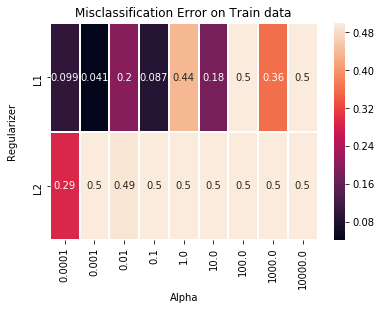

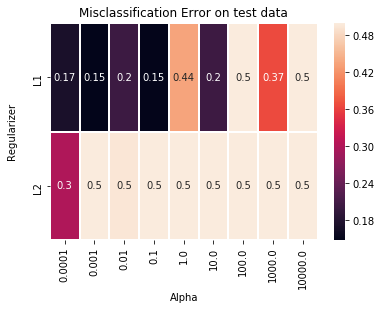

In [74]:
def plot_error_vs_c_r(gsv):
    x1=[0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0,10000.0]
    y1=gsv.cv_results_['mean_test_score'][:9]
    y2=gsv.cv_results_['mean_test_score'][9:]
    y1=1-y1
    y2=1-y2
    heatmap = sn.heatmap([y1,y2], linewidths=1,# cmap=color,
                 xticklabels=[0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0,10000.0], yticklabels=['L1','L2'],annot=True).set_title("Misclassification Error on test data")
    plt.xlabel("Alpha\n")
    plt.ylabel("Regularizer\n")
    plt.show()
def plot_error_vs_tr(gsv):
    x1=[0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0,10000.0]
    y1=gsv.cv_results_['mean_train_score'][:9]
    y2=gsv.cv_results_['mean_train_score'][9:]
    y1=1-y1
    y2=1-y2
    heatmap = sn.heatmap([y1,y2], linewidths=1,# cmap=color,
                 xticklabels=[0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0,10000.0], yticklabels=['L1','L2'],annot=True).set_title("Misclassification Error on Train data")
    plt.xlabel("Alpha\n")
    plt.ylabel("Regularizer\n")
    plt.show()

plot_error_vs_tr(gscv)

    
plot_error_vs_c_r(gscv)

Confusion matrix using train data


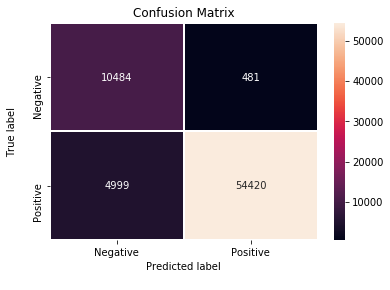

In [75]:
def cnf_mat(y_test,y_pred):
    Conf_matrix=confusion_matrix(y_test, y_pred)
    class_names=['Negative','Positive']
    heatmap = sn.heatmap(Conf_matrix, linewidths=1,# cmap=color,
                 xticklabels=class_names, yticklabels=class_names,annot=True, fmt="d",).set_title("Confusion Matrix")
    plt.xlabel("Predicted label\n")
    plt.ylabel("True label\n")
    plt.show()
print("Confusion matrix using train data")
cnf_mat(y_train,y_pred_train)

Confusion matrix using test data


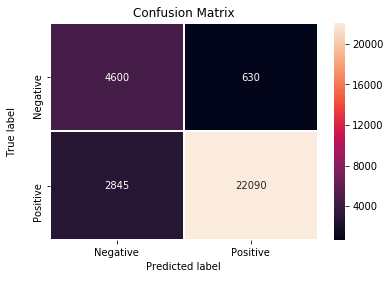

In [76]:
Conf_matrix=confusion_matrix(y_test, y_pred)
from matplotlib import *
import seaborn as sn
#color=sns.color_palette("Blues",6)
class_names=['Negative','Positive']
heatmap = sn.heatmap(Conf_matrix, linewidths=1,# cmap=color,
                 xticklabels=class_names, yticklabels=class_names,annot=True, fmt="d",).set_title("Confusion Matrix")
plt.xlabel("Predicted label\n")
plt.ylabel("True label\n")
print("Confusion matrix using test data")
plt.show()

In [46]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))  
tn,fp,fn,tp=Conf_matrix.ravel()

tpr= float(tp/(tp+fn))
fpr=float(fp/(fp+tn))
tnr=float(tn/(tn+fp))
fnr=float(fn/(fn+tp))

print('TPR = %f \n FPR = %f \n TNR = %f \n FNR = %f'%(tpr,fpr,tnr,fnr))

              precision    recall  f1-score   support

           0       0.62      0.88      0.73      5230
           1       0.97      0.89      0.93     24935

   micro avg       0.88      0.88      0.88     30165
   macro avg       0.80      0.88      0.83     30165
weighted avg       0.91      0.88      0.89     30165

TPR = 0.885903 
 FPR = 0.120459 
 TNR = 0.879541 
 FNR = 0.114097


In [51]:
coef = gscv.best_estimator_.coef_.tolist()[0]
coeff_df = pd.DataFrame({'Word' : bow_fnames, 'Coefficient' : coef})
coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
print('')
print('-Top 10 positive features-')
print('****************************')
print(coeff_df.head(10).to_string(index=False))
print('-'*50)
print('-Top 10 negative features-')
print('****************************')
print(coeff_df.tail(10).to_string(index=False))


-Top 10 positive features-
****************************
Word  Coefficient
     best     5.042756
     good     4.998780
delicious     4.210256
    great     4.018192
    loves     3.412608
  perfect     3.033909
excellent     2.942291
     nice     2.716622
wonderful     2.583289
    tasty     2.483134
--------------------------------------------------
-Top 10 negative features-
****************************
Word  Coefficient
          weak    -2.208769
disappointment    -2.344519
         stale    -2.354352
 disappointing    -2.360189
      horrible    -2.449704
      terrible    -2.515085
         bland    -2.642306
         awful    -2.898059
         worst    -3.155587
           not    -5.533704


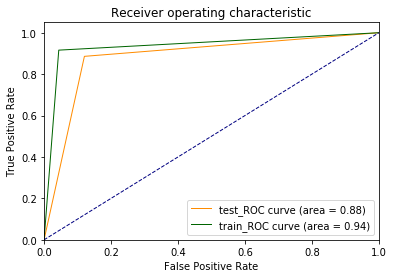

In [77]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

t_fpr, t_tpr, t_thresholds = roc_curve(y_train, y_pred_train)
t_roc_auc = auc(t_fpr, t_tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='test_ROC curve (area = %0.2f)' % roc_auc)
plt.plot(t_fpr, t_tpr, color='darkgreen', lw=1, label='train_ROC curve (area = %0.2f)' % t_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [78]:
# Please write all the code with proper documentation
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)
tf_fnames=tf_idf_vect.get_feature_names()
final_tf_idf_train = tf_idf_vect.transform(X_train)
print("the type of count vectorizer ",type(final_tf_idf_train))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_train.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_train.get_shape()[1])
#applying same on test data
final_tf_idf_test = tf_idf_vect.transform(X_test)
print("the type of count vectorizer ",type(final_tf_idf_test))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_test.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_test.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aback', 'abandon', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able buy', 'able chew']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (70384, 41434)
the number of unique words including both unigrams and bigrams  41434
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (30165, 41434)
the number of unique words including both unigrams and bigrams  41434


In [79]:
pre_mod=MaxAbsScaler().fit(final_tf_idf_train)
std_tfidf_train=pre_mod.transform(final_tf_idf_train)
std_tfidf_test=pre_mod.transform(final_tf_idf_test)
print(std_tfidf_train.shape,'\n',std_tfidf_test.shape)

(70384, 41434) 
 (30165, 41434)


In [80]:
tss=TimeSeriesSplit(n_splits=5).split(std_tfidf_train)
gscv=GridSearchCV(estimator=lr,scoring=score,cv=tss,param_grid=parameter,verbose=1)
gscv.fit(std_tfidf_train,y_train)
print('*'*50)
print("\nThe Best parameters are as follows :")
print("Best Parameteres are as follows : ",gscv.best_params_)
print("Best Accuracy : %.2f%%"%(gscv.best_score_*100))

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   27.8s finished


**************************************************

The Best parameters are as follows :
Best Parameteres are as follows :  {'alpha': 0.001, 'penalty': 'l2'}
Best Accuracy : 86.92%


In [81]:
clf_calibrated=CalibratedClassifierCV(gscv,cv="prefit", method="isotonic")
clf_calibrated.fit(std_tfidf_train, y_train)
print("mean accuracy on the given test data and labels = ",clf_calibrated.score(std_tfidf_train,y_train)*100)

mean accuracy on the given test data and labels =  94.5754716981132


In [85]:
best_lr=SGDClassifier(alpha=0.001,loss='hinge',penalty='l2',random_state=42,n_jobs=-1,class_weight='balanced')
best_lr.fit(std_tfidf_train,y_train)
y_pred=best_lr.predict(std_tfidf_test)
y_pred_train=best_lr.predict(std_tfidf_train)
print("ROC_AUC Score of train set : ",roc_auc_score(y_train,y_pred_train)*100)
print("ROC_AUC Score of test set : ",roc_auc_score(y_test,y_pred)*100)
print("Sparsity/Non-zero counts : ",np.count_nonzero(best_lr.coef_))

ROC_AUC Score of train set :  92.01275073823038
ROC_AUC Score of test set :  89.24600903074572
Sparsity/Non-zero counts :  41427


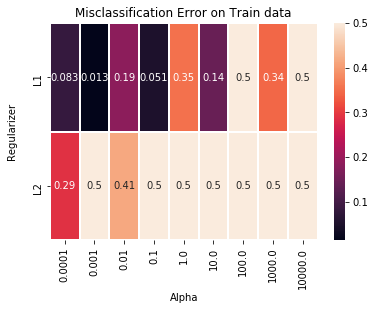

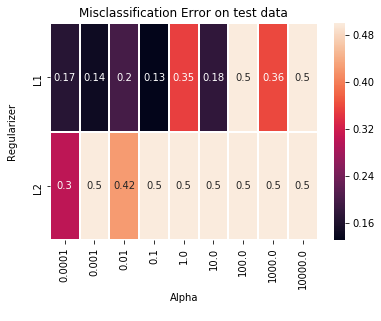

In [86]:
plot_error_vs_tr(gscv)
plot_error_vs_c_r(gscv)

Confusion matrix using train data


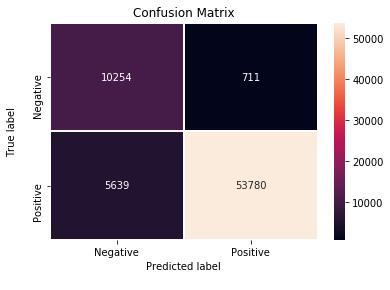

In [89]:
print("Confusion matrix using train data")
cnf_mat(y_train,y_pred_train)

Confusion matrix using test data


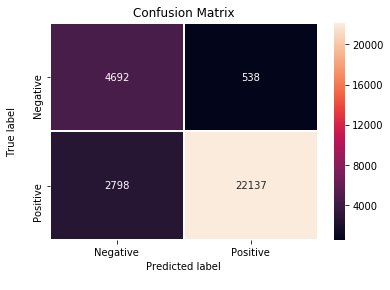

In [90]:
Conf_matrix=confusion_matrix(y_test, y_pred)
from matplotlib import *
import seaborn as sn
#color=sns.color_palette("Blues",6)
class_names=['Negative','Positive']
heatmap = sn.heatmap(Conf_matrix, linewidths=1,# cmap=color,
                 xticklabels=class_names, yticklabels=class_names,annot=True, fmt="d",).set_title("Confusion Matrix")
plt.xlabel("Predicted label\n")
plt.ylabel("True label\n")
print("Confusion matrix using test data")
plt.show()

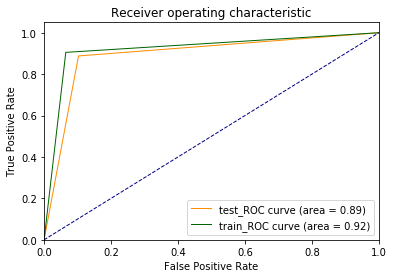

In [91]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

t_fpr, t_tpr, t_thresholds = roc_curve(y_train, y_pred_train)
t_roc_auc = auc(t_fpr, t_tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='test_ROC curve (area = %0.2f)' % roc_auc)
plt.plot(t_fpr, t_tpr, color='darkgreen', lw=1, label='train_ROC curve (area = %0.2f)' % t_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [62]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))  
tn,fp,fn,tp=Conf_matrix.ravel()

tpr= float(tp/(tp+fn))
fpr=float(fp/(fp+tn))
tnr=float(tn/(tn+fp))
fnr=float(fn/(fn+tp))

print('TPR = %f \n FPR = %f \n TNR = %f \n FNR = %f'%(tpr,fpr,tnr,fnr))

              precision    recall  f1-score   support

           0       0.61      0.85      0.71      5230
           1       0.97      0.89      0.92     24935

   micro avg       0.88      0.88      0.88     30165
   macro avg       0.79      0.87      0.82     30165
weighted avg       0.90      0.88      0.89     30165

TPR = 0.887909 
 FPR = 0.152964 
 TNR = 0.847036 
 FNR = 0.112091


In [63]:
coef = gscv.best_estimator_.coef_.tolist()[0]
coeff_df = pd.DataFrame({'Word' : tf_fnames, 'Coefficient' : coef})
coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
print('')
print('-Top 10 positive features-')
print('****************************')
print(coeff_df.head(10).to_string(index=False))
print('-'*50)
print('-Top 10 negative features-')
print('****************************')
print(coeff_df.tail(10).to_string(index=False))


-Top 10 positive features-
****************************
Word  Coefficient
    great     2.071990
     best     1.684621
delicious     1.461175
     good     1.389992
  perfect     1.370583
     love     1.313164
    loves     1.258491
     nice     1.098355
wonderful     1.094580
     easy     0.945166
--------------------------------------------------
-Top 10 negative features-
****************************
Word  Coefficient
unfortunately    -1.032081
     terrible    -1.071025
          bad    -1.079250
        awful    -1.100323
      thought    -1.101444
disappointing    -1.128050
        worst    -1.236828
     not good    -1.283411
 disappointed    -1.366181
          not    -1.410384


### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [92]:
# Please write all the code with proper documentation
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [93]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model_train=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
print(w2v_model_train.wv.most_similar('great'))
print('='*50)
print(w2v_model_train.wv.most_similar('worst'))
# min_count = 5 considers only words that occured atleast 5 times
w2v_model_test=Word2Vec(list_of_sentance_test,min_count=5,size=50, workers=4)
print(w2v_model_test.wv.most_similar('great'))
print('='*50)
print(w2v_model_test.wv.most_similar('worst')) 

[('good', 0.8176319599151611), ('fantastic', 0.8109234571456909), ('awesome', 0.804851233959198), ('excellent', 0.8041814565658569), ('terrific', 0.7915872931480408), ('wonderful', 0.759940505027771), ('perfect', 0.7210546135902405), ('decent', 0.7124065160751343), ('fabulous', 0.7064300775527954), ('nice', 0.6909266710281372)]
[('greatest', 0.7638792991638184), ('best', 0.7402584552764893), ('tastiest', 0.7009475231170654), ('disgusting', 0.6466666460037231), ('closest', 0.6378547549247742), ('nastiest', 0.6345558762550354), ('coolest', 0.6101095676422119), ('smoothest', 0.6002094745635986), ('horrible', 0.5903129577636719), ('wins', 0.5737779140472412)]
[('awesome', 0.8425755500793457), ('excellent', 0.8059988617897034), ('fantastic', 0.8051949143409729), ('wonderful', 0.79734206199646), ('good', 0.7584332227706909), ('perfect', 0.7583256363868713), ('amazing', 0.7548903226852417), ('fabulous', 0.6963754892349243), ('terrific', 0.6854687333106995), ('delicious', 0.6508586406707764)]


In [94]:
w2v_words_train = list(w2v_model_train.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_train))
print("sample words ", w2v_words_train[0:50])

w2v_words_test = list(w2v_model_test.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_test))
print("sample words ", w2v_words_test[0:50])

number of words that occured minimum 5 times  15774
sample words  ['bought', 'apartment', 'infested', 'fruit', 'flies', 'hours', 'trap', 'attracted', 'many', 'within', 'days', 'practically', 'gone', 'may', 'not', 'long', 'term', 'solution', 'driving', 'crazy', 'consider', 'buying', 'one', 'caution', 'surface', 'sticky', 'try', 'avoid', 'touching', 'really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'love', 'call']
number of words that occured minimum 5 times  10505
sample words  ['glad', 'found', 'larger', 'bag', 'best', 'coffee', 'ever', 'go', 'longer', 'reorder', 'follow', 'directions', 'not', 'add', 'sugar', 'sweetner', 'cream', 'milk', 'puts', 'starbucks', 'shame', 'still', 'think', 'keurig', 'idea', 'thing', 'since', 'grinder', 'problems', 'machines', 'put', 'good', 'get', 'great', 'job', 'customer', 'service', 'experience', 'buying', 'tully', 'roast', 

In [95]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|███████████████████████████████████| 70384/70384 [06:39<00:00, 176.04it/s]


70384
50


In [96]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████| 30165/30165 [02:55<00:00, 171.92it/s]


30165
50


In [97]:
pre_mod=MaxAbsScaler().fit(sent_vectors_train)
std_aw2v_train=pre_mod.transform(sent_vectors_train)
std_aw2v_test=pre_mod.transform(sent_vectors_test)
print(std_aw2v_train.shape,'\n',std_aw2v_test.shape)

(70384, 50) 
 (30165, 50)


In [98]:
tss=TimeSeriesSplit(n_splits=5).split(std_aw2v_train)
gscv=GridSearchCV(estimator=lr,scoring=score,cv=tss,param_grid=parameter,verbose=1)
gscv.fit(std_aw2v_train,y_train)

print("Best Parameteres are as follows : ",gscv.best_params_)
print("Best ROC_AUC : %.2f%%"%(gscv.best_score_*100))

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   21.6s finished


Best Parameteres are as follows :  {'alpha': 0.001, 'penalty': 'l1'}
Best ROC_AUC : 81.94%


In [99]:
clf_calibrated=CalibratedClassifierCV(gscv,cv="prefit", method="isotonic")
clf_calibrated.fit(std_aw2v_train, y_train)
print("mean accuracy on the given test data and labels = ",clf_calibrated.score(std_aw2v_train,y_train)*100)

mean accuracy on the given test data and labels =  88.78438281427597


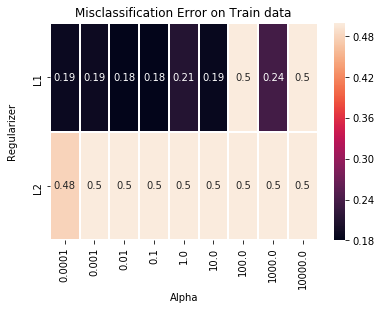

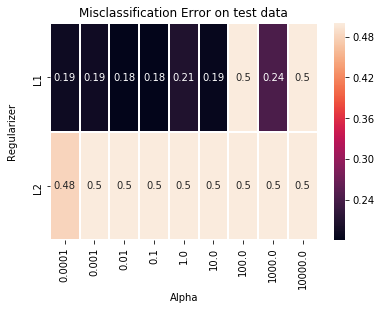

In [100]:
plot_error_vs_tr(gscv)
plot_error_vs_c_r(gscv)

In [101]:
best_lr=SGDClassifier(alpha=0.001,loss='hinge',penalty='l2',random_state=42,n_jobs=-1,class_weight='balanced')
best_lr.fit(std_aw2v_train,y_train)
y_pred=best_lr.predict(std_aw2v_test)
y_pred_train=best_lr.predict(std_aw2v_train)
print("ROC_AUC Score of train set : ",roc_auc_score(y_train,y_pred_train)*100)
print("ROC_AUC Score of test set : ",roc_auc_score(y_test,y_pred)*100)
print("Sparsity/Non-zero counts : ",np.count_nonzero(best_lr.coef_))

ROC_AUC Score of train set :  82.48175525358347
ROC_AUC Score of test set :  82.32899228241995
Sparsity/Non-zero counts :  50


Confusion matrix using Train data


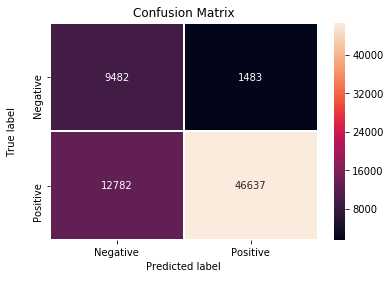

In [102]:
print("Confusion matrix using Train data")
cnf_mat(y_train,y_pred_train)

Confusion matrix using Test data


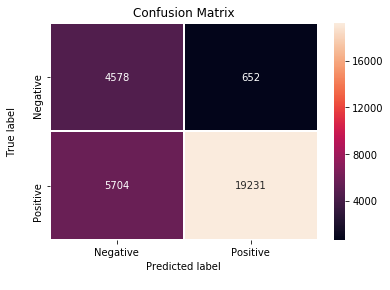

In [103]:
Conf_matrix=confusion_matrix(y_test, y_pred)
from matplotlib import *
import seaborn as sn
#color=sns.color_palette("Blues",6)
class_names=['Negative','Positive']
heatmap = sn.heatmap(Conf_matrix, linewidths=1,# cmap=color,
                 xticklabels=class_names, yticklabels=class_names,annot=True, fmt="d",).set_title("Confusion Matrix")
plt.xlabel("Predicted label\n")
plt.ylabel("True label\n")
print("Confusion matrix using Test data")
plt.show()

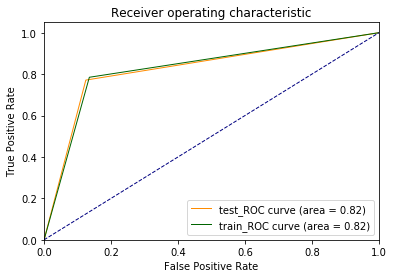

In [104]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

t_fpr, t_tpr, t_thresholds = roc_curve(y_train, y_pred_train)
t_roc_auc = auc(t_fpr, t_tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='test_ROC curve (area = %0.2f)' % roc_auc)
plt.plot(t_fpr, t_tpr, color='darkgreen', lw=1, label='train_ROC curve (area = %0.2f)' % t_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [76]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))  
tn,fp,fn,tp=Conf_matrix.ravel()

tpr= float(tp/(tp+fn))
fpr=float(fp/(fp+tn))
tnr=float(tn/(tn+fp))
fnr=float(fn/(fn+tp))

print('TPR = %f \n FPR = %f \n TNR = %f \n FNR = %f'%(tpr,fpr,tnr,fnr))

              precision    recall  f1-score   support

           0       0.44      0.88      0.59      5230
           1       0.97      0.77      0.86     24935

   micro avg       0.79      0.79      0.79     30165
   macro avg       0.70      0.82      0.72     30165
weighted avg       0.88      0.79      0.81     30165

TPR = 0.766834 
 FPR = 0.120459 
 TNR = 0.879541 
 FNR = 0.233166


### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [105]:
# Please write all the code with proper documentation
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix_train = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [106]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████████████████████████████| 70384/70384 [2:00:47<00:00,  9.71it/s]


In [107]:

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|████████████████████████████████████| 30165/30165 [46:20<00:00, 10.85it/s]


In [108]:
pre_mod=MaxAbsScaler().fit(tfidf_sent_vectors_train)
std_taw2v_train=pre_mod.transform(tfidf_sent_vectors_train)
std_taw2v_test=pre_mod.transform(tfidf_sent_vectors_test)
print(std_taw2v_train.shape,'\n',std_taw2v_test.shape)

(70384, 50) 
 (30165, 50)


In [109]:
tss=TimeSeriesSplit(n_splits=5).split(std_taw2v_train)
gscv=GridSearchCV(estimator=lr,scoring=score,cv=tss,param_grid=parameter,verbose=1)
gscv.fit(std_taw2v_train,y_train)
print("Best Parameteres are as follows : ",gscv.best_params_)
print("Best Accuracy : %.2f%%"%(gscv.best_score_*100))

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   22.7s finished


Best Parameteres are as follows :  {'alpha': 0.001, 'penalty': 'l2'}
Best Accuracy : 79.33%


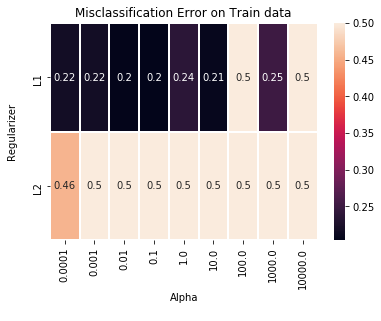

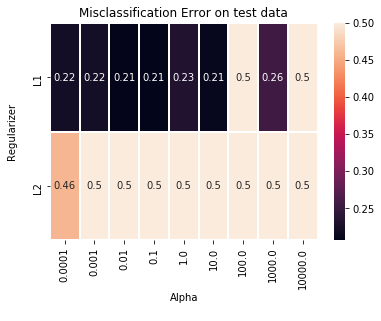

In [110]:
plot_error_vs_tr(gscv)
plot_error_vs_c_r(gscv)

In [111]:
best_lr=SGDClassifier(alpha=0.001,loss='hinge',penalty='l2',random_state=42,n_jobs=-1,class_weight='balanced')
best_lr.fit(std_taw2v_train,y_train)
y_pred=best_lr.predict(std_taw2v_test)
y_pred_train=best_lr.predict(std_taw2v_train)
print("ROC_AUC Score of train set : ",roc_auc_score(y_train,y_pred_train)*100)
print("ROC_AUC Score of test set : ",roc_auc_score(y_test,y_pred)*100)
print("Sparsity/Non-zero counts : ",np.count_nonzero(best_lr.coef_))

ROC_AUC Score of train set :  79.87200507249608
ROC_AUC Score of test set :  79.42458997600261
Sparsity/Non-zero counts :  50


Confusion matrix using train data


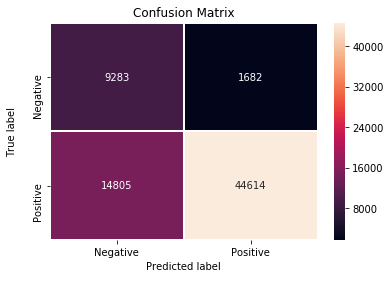

In [112]:
print("Confusion matrix using train data")
cnf_mat(y_train,y_pred_train)

Confusion matrix using Test data


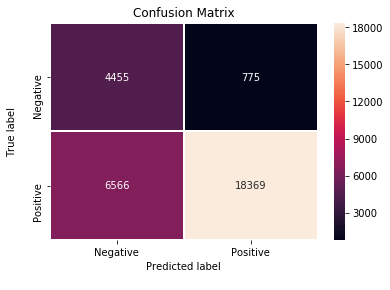

In [113]:
Conf_matrix=confusion_matrix(y_test, y_pred)
from matplotlib import *
import seaborn as sn
#color=sns.color_palette("Blues",6)
class_names=['Negative','Positive']
heatmap = sn.heatmap(Conf_matrix, linewidths=1,# cmap=color,
                 xticklabels=class_names, yticklabels=class_names,annot=True, fmt="d",).set_title("Confusion Matrix")
plt.xlabel("Predicted label\n")
plt.ylabel("True label\n")
print("Confusion matrix using Test data")
plt.show()

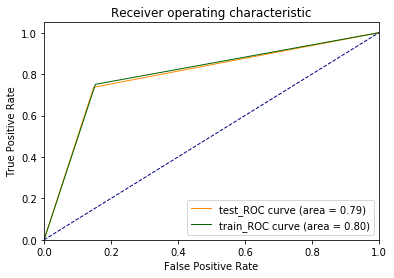

In [114]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

t_fpr, t_tpr, t_thresholds = roc_curve(y_train, y_pred_train)
t_roc_auc = auc(t_fpr, t_tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='test_ROC curve (area = %0.2f)' % roc_auc)
plt.plot(t_fpr, t_tpr, color='darkgreen', lw=1, label='train_ROC curve (area = %0.2f)' % t_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [86]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))  
tn,fp,fn,tp=Conf_matrix.ravel()

tpr= float(tp/(tp+fn))
fpr=float(fp/(fp+tn))
tnr=float(tn/(tn+fp))
fnr=float(fn/(fn+tp))

print('TPR = %f \n FPR = %f \n TNR = %f \n FNR = %f'%(tpr,fpr,tnr,fnr))

              precision    recall  f1-score   support

           0       0.40      0.85      0.55      5230
           1       0.96      0.74      0.83     24935

   micro avg       0.76      0.76      0.76     30165
   macro avg       0.68      0.80      0.69     30165
weighted avg       0.86      0.76      0.78     30165

TPR = 0.736595 
 FPR = 0.145889 
 TNR = 0.854111 
 FNR = 0.263405


## [5.2] RBF SVM

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [15]:
# Please write all the code with proper documentation
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)
bow_fnames=count_vect.get_feature_names()
final_counts_train = count_vect.transform(X_train)
print("the type of count vectorizer ",type(final_counts_train))
print("the shape of out text BOW vectorizer ",final_counts_train.get_shape())
print("the number of unique words ", final_counts_train.get_shape()[1])

final_counts_test = count_vect.transform(X_test)
print("the type of count vectorizer ",type(final_counts_test))
print("the shape of out text BOW vectorizer ",final_counts_test.get_shape())
print("the number of unique words ", final_counts_test.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaand', 'aaah', 'aadp', 'aafco', 'aahing']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (16767, 24568)
the number of unique words  24568
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (7186, 24568)
the number of unique words  24568


In [16]:
# Standardsing features using preprocessing algorithm
from sklearn import preprocessing
from sklearn.preprocessing import MaxAbsScaler
pre_mod=MaxAbsScaler().fit(final_counts_train)
std_bow_train=pre_mod.transform(final_counts_train)
std_bow_test=pre_mod.transform(final_counts_test)
print(std_bow_train.shape,'\n',std_bow_test.shape)

(16767, 24568) 
 (7186, 24568)


In [17]:
#Converting to lower dimensions here i am taking 500 dimensions using truncatedSVD
from sklearn.decomposition import TruncatedSVD
tsvd_model=TruncatedSVD(n_components=500,n_iter=7,random_state=14)

fin_train_tsvd=tsvd_model.fit_transform(final_counts_train)

print(type(fin_train_tsvd))
print('\n shape of trained and reduced final data is : ',fin_train_tsvd.shape)



<class 'numpy.ndarray'>

 shape of trained and reduced final data is :  (16767, 500)


In [18]:
fin_test_tsvd=tsvd_model.transform(std_bow_test)

print(type(fin_test_tsvd))
print('\n shape of trained and reduced final data is : ',fin_test_tsvd.shape)


<class 'numpy.ndarray'>

 shape of trained and reduced final data is :  (7186, 500)


In [19]:
std_bow_train=fin_train_tsvd
std_bow_test=fin_test_tsvd

In [21]:
from sklearn.svm import SVC
from prettytable import PrettyTable
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score,average_precision_score,roc_auc_score,auc

lr=SVC(random_state=42,class_weight='balanced')
parameter={'C':[0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0,10000.0],'gamma':[0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0,10000.0]}
tss=TimeSeriesSplit(n_splits=5).split(std_bow_train)
score=make_scorer(roc_auc_score,average='weighted')

gscv=GridSearchCV(estimator=lr,scoring=score,cv=tss,param_grid=parameter,verbose=1)

gscv.fit(std_bow_train,y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed: 2308.1min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x00000000054D1938>,
       error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(roc_auc_score, average=weighted), verbose=1)

In [22]:
print("Best Parameteres are as follows : ",gscv.best_params_)
print("Best ROC_AUC_Score : %.2f%%"%(gscv.best_score_*100))
print(gscv.cv_results_['mean_test_score'].shape)

Best Parameteres are as follows :  {'C': 100.0, 'gamma': 0.001}
Best ROC_AUC_Score : 82.45%
(81,)


In [45]:
from sklearn.svm import SVC
from prettytable import PrettyTable
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score,average_precision_score,roc_auc_score,auc
best_lr=SVC(C=100.0,gamma=0.001,random_state=42,class_weight='balanced')
best_lr.fit(std_bow_train,y_train)
y_pred=best_lr.predict(std_bow_test)
y_pred_train=best_lr.predict(std_bow_train)

print("ROC_AUC Score of train set : ",roc_auc_score(y_train,y_pred_train)*100)
print("ROC_AUC Score of test set : ",roc_auc_score(y_test,y_pred)*100)

ROC_AUC Score of train set :  90.77327603041778
ROC_AUC Score of test set :  83.94718229417937


Confusion Matrix using Training data


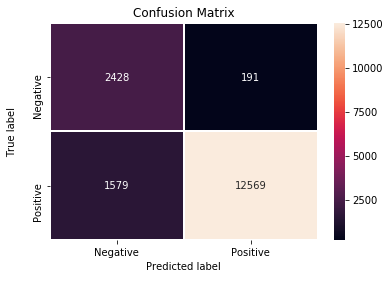

In [22]:
Conf_matrix=confusion_matrix(y_train, y_pred_train)
from matplotlib import *
import seaborn as sn
#color=sns.color_palette("Blues",6)
class_names=['Negative','Positive']
heatmap = sn.heatmap(Conf_matrix, linewidths=1,# cmap=color,
                 xticklabels=class_names, yticklabels=class_names,annot=True, fmt="d",).set_title("Confusion Matrix")
plt.xlabel("Predicted label\n")
plt.ylabel("True label\n")
print("Confusion Matrix using Training data")
plt.show()

Confusion Matrix using Test data


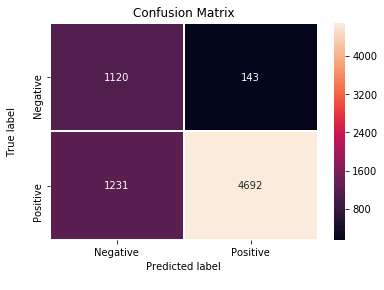

In [23]:
Conf_matrix=confusion_matrix(y_test, y_pred)
from matplotlib import *
import seaborn as sn
#color=sns.color_palette("Blues",6)
class_names=['Negative','Positive']
heatmap = sn.heatmap(Conf_matrix, linewidths=1,# cmap=color,
                 xticklabels=class_names, yticklabels=class_names,annot=True, fmt="d",).set_title("Confusion Matrix")
plt.xlabel("Predicted label\n")
plt.ylabel("True label\n")
print("Confusion Matrix using Test data")
plt.show()

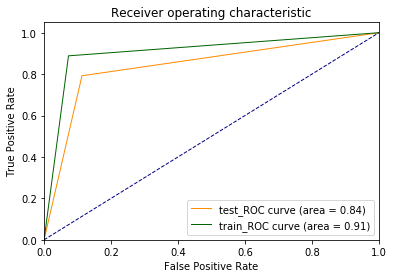

In [24]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

t_fpr, t_tpr, t_thresholds = roc_curve(y_train, y_pred_train)
t_roc_auc = auc(t_fpr, t_tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='test_ROC curve (area = %0.2f)' % roc_auc)
plt.plot(t_fpr, t_tpr, color='darkgreen', lw=1, label='train_ROC curve (area = %0.2f)' % t_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))  
tn,fp,fn,tp=Conf_matrix.ravel()

tpr= float(tp/(tp+fn))
fpr=float(fp/(fp+tn))
tnr=float(tn/(tn+fp))
fnr=float(fn/(fn+tp))

print('TPR = %f \n FPR = %f \n TNR = %f \n FNR = %f'%(tpr,fpr,tnr,fnr))

              precision    recall  f1-score   support

           0       0.57      0.86      0.69      1263
           1       0.97      0.86      0.91      5923

   micro avg       0.86      0.86      0.86      7186
   macro avg       0.77      0.86      0.80      7186
weighted avg       0.90      0.86      0.87      7186

TPR = 0.860712 
 FPR = 0.138559 
 TNR = 0.861441 
 FNR = 0.139288


### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [25]:
# Please write all the code with proper documentation
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)
tf_fnames=tf_idf_vect.get_feature_names()
final_tf_idf_train = tf_idf_vect.transform(X_train)
print("the type of count vectorizer ",type(final_tf_idf_train))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_train.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_train.get_shape()[1])
#applying same on test data
final_tf_idf_test = tf_idf_vect.transform(X_test)
print("the type of count vectorizer ",type(final_tf_idf_test))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_test.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_test.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able drink', 'able eat', 'able enjoy', 'able find', 'able get', 'able give', 'able make']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (16767, 10538)
the number of unique words including both unigrams and bigrams  10538
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (7186, 10538)
the number of unique words including both unigrams and bigrams  10538


In [26]:
tsvd_model=TruncatedSVD(n_components=300,n_iter=7,random_state=14)

fin_train_tsvd=tsvd_model.fit_transform(final_tf_idf_train)

print(type(fin_train_tsvd))
print('\n shape of trained and reduced final data is : ',fin_train_tsvd.shape)


<class 'numpy.ndarray'>

 shape of trained and reduced final data is :  (16767, 300)


In [27]:
fin_test_tsvd=tsvd_model.transform(final_tf_idf_test)

print(type(fin_test_tsvd))
print('\n shape of trained and reduced final data is : ',fin_test_tsvd.shape)


<class 'numpy.ndarray'>

 shape of trained and reduced final data is :  (7186, 300)


In [28]:
final_tf_idf_test=fin_test_tsvd
final_tf_idf_train=fin_train_tsvd

In [29]:
pre_mod=MaxAbsScaler().fit(final_tf_idf_train)
std_tfidf_train=pre_mod.transform(final_tf_idf_train)
std_tfidf_test=pre_mod.transform(final_tf_idf_test)
print(std_tfidf_train.shape,'\n',std_tfidf_test.shape)

(16767, 300) 
 (7186, 300)


In [34]:
tss=TimeSeriesSplit(n_splits=5).split(std_tfidf_train)
gscv=GridSearchCV(estimator=lr,scoring=score,cv=tss,param_grid=parameter,verbose=1)

gscv.fit(std_tfidf_train,y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed: 1675.1min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000000017E16728>,
       error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(roc_auc_score, average=weighted), verbose=1)

In [35]:
print("Best Parameteres are as follows : ",gscv.best_params_)
print("Best ROC_AUC_Score : %.2f%%"%(gscv.best_score_*100))
print(gscv.cv_results_['mean_test_score'].shape)

Best Parameteres are as follows :  {'C': 100.0, 'gamma': 0.001}
Best ROC_AUC_Score : 82.16%
(81,)


In [46]:
best_lr=SVC(C=100.0,gamma=0.001,random_state=42,class_weight='balanced')
best_lr.fit(std_tfidf_train,y_train)
y_pred=best_lr.predict(std_tfidf_test)
y_pred_train=best_lr.predict(std_tfidf_train)

print("ROC_AUC Score of train set : ",roc_auc_score(y_train,y_pred_train)*100)
print("ROC_AUC Score of test set : ",roc_auc_score(y_test,y_pred)*100)

ROC_AUC Score of train set :  87.35167842746344
ROC_AUC Score of test set :  85.95776305287077


 Confusion matrix using Train data


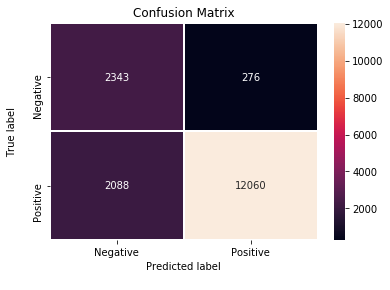

In [32]:
Conf_matrix=confusion_matrix(y_train, y_pred_train)
from matplotlib import *
import seaborn as sn
#color=sns.color_palette("Blues",6)
class_names=['Negative','Positive']
heatmap = sn.heatmap(Conf_matrix, linewidths=1,# cmap=color,
                 xticklabels=class_names, yticklabels=class_names,annot=True, fmt="d",).set_title("Confusion Matrix")
plt.xlabel("Predicted label\n")
plt.ylabel("True label\n")
print(" Confusion matrix using Train data")
plt.show()

 Confusion matrix using Test data


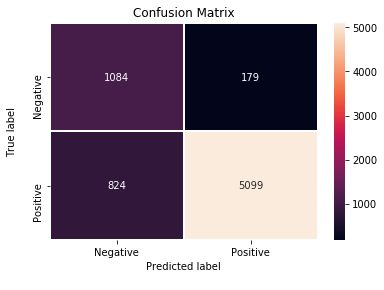

In [33]:
Conf_matrix=confusion_matrix(y_test, y_pred)
from matplotlib import *
import seaborn as sn
#color=sns.color_palette("Blues",6)
class_names=['Negative','Positive']
heatmap = sn.heatmap(Conf_matrix, linewidths=1,# cmap=color,
                 xticklabels=class_names, yticklabels=class_names,annot=True, fmt="d",).set_title("Confusion Matrix")
plt.xlabel("Predicted label\n")
plt.ylabel("True label\n")
print(" Confusion matrix using Test data")
plt.show()

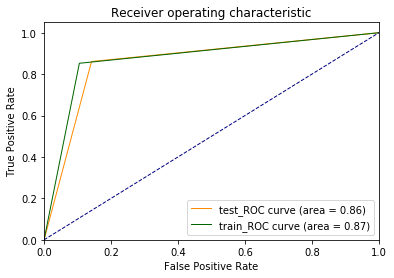

In [34]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

t_fpr, t_tpr, t_thresholds = roc_curve(y_train, y_pred_train)
t_roc_auc = auc(t_fpr, t_tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='test_ROC curve (area = %0.2f)' % roc_auc)
plt.plot(t_fpr, t_tpr, color='darkgreen', lw=1, label='train_ROC curve (area = %0.2f)' % t_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [40]:
print(classification_report(y_test, y_pred))  
tn,fp,fn,tp=Conf_matrix.ravel()

tpr= float(tp/(tp+fn))
fpr=float(fp/(fp+tn))
tnr=float(tn/(tn+fp))
fnr=float(fn/(fn+tp))

print('TPR = %f \n FPR = %f \n TNR = %f \n FNR = %f'%(tpr,fpr,tnr,fnr))

              precision    recall  f1-score   support

           0       0.57      0.86      0.68      1263
           1       0.97      0.86      0.91      5923

   micro avg       0.86      0.86      0.86      7186
   macro avg       0.77      0.86      0.80      7186
weighted avg       0.90      0.86      0.87      7186

TPR = 0.860881 
 FPR = 0.141726 
 TNR = 0.858274 
 FNR = 0.139119


### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [35]:
# Please write all the code with proper documentation
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [36]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model_train=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
print(w2v_model_train.wv.most_similar('great'))
print('='*50)
print(w2v_model_train.wv.most_similar('worst'))
# min_count = 5 considers only words that occured atleast 5 times
w2v_model_test=Word2Vec(list_of_sentance_test,min_count=5,size=50, workers=4)
print(w2v_model_test.wv.most_similar('great'))
print('='*50)
print(w2v_model_test.wv.most_similar('worst')) 

[('fantastic', 0.8220891356468201), ('good', 0.817979633808136), ('excellent', 0.8118917942047119), ('wonderful', 0.7971062064170837), ('perfect', 0.7619179487228394), ('awesome', 0.759880006313324), ('amazing', 0.7499535083770752), ('decent', 0.7263216972351074), ('delicious', 0.6709831357002258), ('tasty', 0.6653581857681274)]
[('hooked', 0.870477557182312), ('amongst', 0.8685632944107056), ('personal', 0.8595079183578491), ('repulsive', 0.8482298254966736), ('britt', 0.8472926616668701), ('jamaican', 0.8402034044265747), ('world', 0.8401668667793274), ('admit', 0.8387320041656494), ('jamaica', 0.8379114270210266), ('fond', 0.8373677730560303)]
[('good', 0.9501527547836304), ('excellent', 0.9492440223693848), ('better', 0.9151603579521179), ('quality', 0.912089467048645), ('amazing', 0.9111167788505554), ('acquired', 0.9004396200180054), ('wonderful', 0.8974415063858032), ('value', 0.8897365927696228), ('hammer', 0.8883121609687805), ('unbelievable', 0.8848387598991394)]
[('hooked', 

In [37]:
w2v_words_train = list(w2v_model_train.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_train))
print("sample words ", w2v_words_train[0:50])

w2v_words_test = list(w2v_model_test.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_test))
print("sample words ", w2v_words_test[0:50])

number of words that occured minimum 5 times  7883
sample words  ['really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'bought', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'stickers', 'removed', 'easily', 'daughter', 'designed', 'signs', 'printed', 'reverse', 'windows', 'beautifully', 'print', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'chatchi', 'favorite', 'afternoon', 'treat', 'became', 'unavailable']
number of words that occured minimum 5 times  4822
sample words  ['love', 'products', 'reduce', 'not', 'hurt', 'eyes', 'look', 'really', 'like', 'drawer', 'cuisinart', 'keurig', 'k', 'cup', 'mini', 'brewing', 'system', 'sturdy', 'enough', 'hold', 'coffee', 'maker', 'product', 'would', 'highly', 'recommend', 'tray', 'fits', 'perfectly', 'color', 'compliments', 'non', 'top', 'keeps', 'place', 'ample', 'storage', 'space', 'tried', '

In [38]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|███████████████████████████████████| 16767/16767 [01:22<00:00, 202.50it/s]


16767
50


In [39]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|█████████████████████████████████████| 7186/7186 [00:27<00:00, 262.85it/s]


7186
50


In [40]:
pre_mod=MaxAbsScaler().fit(sent_vectors_train)
std_aw2v_train=pre_mod.transform(sent_vectors_train)
std_aw2v_test=pre_mod.transform(sent_vectors_test)
print(std_aw2v_train.shape,'\n',std_aw2v_test.shape)

(16767, 50) 
 (7186, 50)


In [48]:
tss=TimeSeriesSplit(n_splits=5).split(std_aw2v_train)
gscv=GridSearchCV(estimator=lr,scoring=score,cv=tss,param_grid=parameter,verbose=1)

gscv.fit(std_aw2v_train,y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed: 414.0min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x00000000055E6DB0>,
       error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(roc_auc_score, average=weighted), verbose=1)

In [49]:
print("Best Parameteres are as follows : ",gscv.best_params_)
print("Best ROC_AUC_Score : %.2f%%"%(gscv.best_score_*100))
print(gscv.cv_results_['mean_test_score'].shape)

Best Parameteres are as follows :  {'C': 10.0, 'gamma': 0.1}
Best ROC_AUC_Score : 78.22%
(81,)


In [41]:
best_lr=SVC(C=10.0,gamma=0.1,random_state=42,class_weight='balanced')
best_lr.fit(std_aw2v_train,y_train)
y_pred=best_lr.predict(std_aw2v_test)
y_pred_train=best_lr.predict(std_aw2v_train)
print("ROC_AUC Score of train set : ",roc_auc_score(y_train,y_pred_train)*100)
print("ROC_AUC Score of test set : ",roc_auc_score(y_test,y_pred)*100)

ROC_AUC Score of train set :  81.01272556100602
ROC_AUC Score of test set :  81.52181686619883


Confusion matrix using Train data


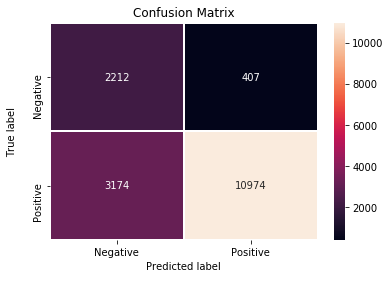

In [42]:
Conf_matrix=confusion_matrix(y_train, y_pred_train)
from matplotlib import *
import seaborn as sn
#color=sns.color_palette("Blues",6)
class_names=['Negative','Positive']
heatmap = sn.heatmap(Conf_matrix, linewidths=1,# cmap=color,
                 xticklabels=class_names, yticklabels=class_names,annot=True, fmt="d",).set_title("Confusion Matrix")
plt.xlabel("Predicted label\n")
plt.ylabel("True label\n")
print("Confusion matrix using Train data")
plt.show()

Confusion matrix using Test data


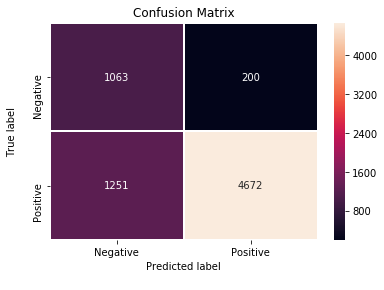

In [43]:
Conf_matrix=confusion_matrix(y_test, y_pred)
from matplotlib import *
import seaborn as sn
#color=sns.color_palette("Blues",6)
class_names=['Negative','Positive']
heatmap = sn.heatmap(Conf_matrix, linewidths=1,# cmap=color,
                 xticklabels=class_names, yticklabels=class_names,annot=True, fmt="d",).set_title("Confusion Matrix")
plt.xlabel("Predicted label\n")
plt.ylabel("True label\n")
print("Confusion matrix using Test data")
plt.show()

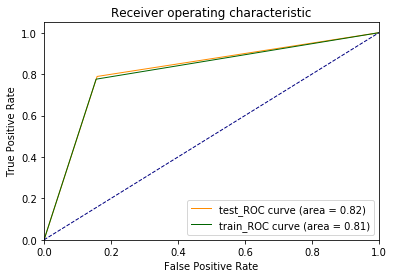

In [44]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

t_fpr, t_tpr, t_thresholds = roc_curve(y_train, y_pred_train)
t_roc_auc = auc(t_fpr, t_tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='test_ROC curve (area = %0.2f)' % roc_auc)
plt.plot(t_fpr, t_tpr, color='darkgreen', lw=1, label='train_ROC curve (area = %0.2f)' % t_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [54]:
print(classification_report(y_test, y_pred))  
tn,fp,fn,tp=Conf_matrix.ravel()

tpr= float(tp/(tp+fn))
fpr=float(fp/(fp+tn))
tnr=float(tn/(tn+fp))
fnr=float(fn/(fn+tp))

print('TPR = %f \n FPR = %f \n TNR = %f \n FNR = %f'%(tpr,fpr,tnr,fnr))

              precision    recall  f1-score   support

           0       0.45      0.83      0.58      1263
           1       0.96      0.78      0.86      5923

   micro avg       0.79      0.79      0.79      7186
   macro avg       0.70      0.81      0.72      7186
weighted avg       0.87      0.79      0.81      7186

TPR = 0.782711 
 FPR = 0.167854 
 TNR = 0.832146 
 FNR = 0.217289


### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [47]:
# Please write all the code with proper documentation
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix_train = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [48]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████| 16767/16767 [10:10<00:00, 27.46it/s]


In [49]:

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████████████████████████████████| 7186/7186 [03:57<00:00, 30.20it/s]


In [51]:
pre_mod=MaxAbsScaler().fit(tfidf_sent_vectors_train)
std_taw2v_train=pre_mod.transform(tfidf_sent_vectors_train)
std_taw2v_test=pre_mod.transform(tfidf_sent_vectors_test)
print(std_taw2v_train.shape,'\n',std_taw2v_test.shape)

(16767, 50) 
 (7186, 50)


In [60]:
tss=TimeSeriesSplit(n_splits=5).split(std_taw2v_train)
gscv=GridSearchCV(estimator=lr,scoring=score,cv=tss,param_grid=parameter,verbose=1)

gscv.fit(std_taw2v_train,y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed: 419.8min finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000000017E163B8>,
       error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(roc_auc_score, average=weighted), verbose=1)

In [61]:
print("Best Parameteres are as follows : ",gscv.best_params_)
print("Best ROC_AUC_Score : %.2f%%"%(gscv.best_score_*100))
print(gscv.cv_results_['mean_test_score'].shape)

Best Parameteres are as follows :  {'C': 10.0, 'gamma': 0.1}
Best ROC_AUC_Score : 76.59%
(81,)


In [52]:
best_lr=SVC(C=10.0,gamma=0.1,random_state=42,class_weight='balanced')
best_lr.fit(std_taw2v_train,y_train)
y_pred=best_lr.predict(std_taw2v_test)
y_pred_train=best_lr.predict(std_taw2v_train)
print("ROC_AUC Score of train set : ",roc_auc_score(y_train,y_pred_train)*100)
print("ROC_AUC Score of test set : ",roc_auc_score(y_test,y_pred)*100)

ROC_AUC Score of train set :  79.95035544712889
ROC_AUC Score of test set :  78.84348880038617


Confusion matrix using Train data


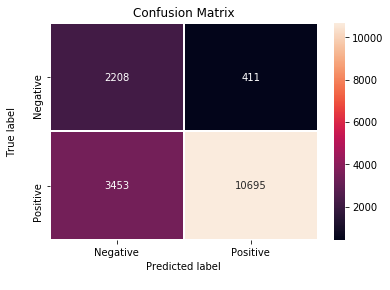

In [53]:
Conf_matrix=confusion_matrix(y_train, y_pred_train)

class_names=['Negative','Positive']
heatmap = sn.heatmap(Conf_matrix, linewidths=1,# cmap=color,
                 xticklabels=class_names, yticklabels=class_names,annot=True, fmt="d",).set_title("Confusion Matrix")
plt.xlabel("Predicted label\n")
plt.ylabel("True label\n")
print("Confusion matrix using Train data")
plt.show()

Confusion matrix using Test data


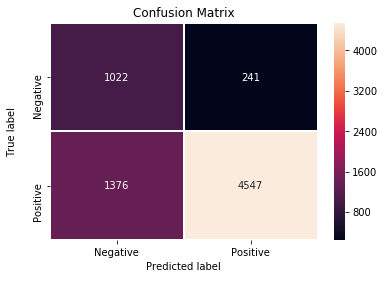

In [54]:
Conf_matrix=confusion_matrix(y_test, y_pred)
from matplotlib import *
import seaborn as sn
#color=sns.color_palette("Blues",6)
class_names=['Negative','Positive']
heatmap = sn.heatmap(Conf_matrix, linewidths=1,# cmap=color,
                 xticklabels=class_names, yticklabels=class_names,annot=True, fmt="d",).set_title("Confusion Matrix")
plt.xlabel("Predicted label\n")
plt.ylabel("True label\n")
print("Confusion matrix using Test data")
plt.show()

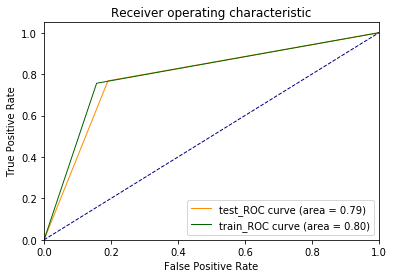

In [55]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
t_fpr, t_tpr, t_thresholds = roc_curve(y_train, y_pred_train)
t_roc_auc = auc(t_fpr, t_tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='test_ROC curve (area = %0.2f)' % roc_auc)
plt.plot(t_fpr, t_tpr, color='darkgreen', lw=1, label='train_ROC curve (area = %0.2f)' % t_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [66]:
print(classification_report(y_test, y_pred))  
tn,fp,fn,tp=Conf_matrix.ravel()

tpr= float(tp/(tp+fn))
fpr=float(fp/(fp+tn))
tnr=float(tn/(tn+fp))
fnr=float(fn/(fn+tp))

print('TPR = %f \n FPR = %f \n TNR = %f \n FNR = %f'%(tpr,fpr,tnr,fnr))

              precision    recall  f1-score   support

           0       0.42      0.81      0.56      1263
           1       0.95      0.77      0.85      5923

   micro avg       0.77      0.77      0.77      7186
   macro avg       0.69      0.79      0.70      7186
weighted avg       0.86      0.77      0.80      7186

TPR = 0.766166 
 FPR = 0.191607 
 TNR = 0.808393 
 FNR = 0.233834


# [6] Conclusions

In [69]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable

x=PrettyTable()

x.field_names=["Vectorizer","Regularizer","Alpha Value","Accuracy/F1-score"]

x.add_row(['BOW','L2','0.0001','88.27'])
x.add_row(['TFIDF','L2','0.001','86.74'])
x.add_row(['Avg-W2V','L2','0.001','82.31'])
x.add_row(['Tfidf weighted W2V','L2','0.001','79.53'])
print('** Conclusion : Accuracy for Amazon review dataset with different vectorizers using Linear SVM\n')
print(x)

y=PrettyTable()

y.field_names=["Vectorizer","C","Gamma Value","Accuracy/F1-score"]

y.add_row(['BOW','100','0.001','86.10'])
y.add_row(['TFIDF','100','0.001','85.95'])
y.add_row(['Avg-W2V','10','0.1','80.74'])
y.add_row(['Tfidf weighted W2V','10','0.1','78.72'])
print('**Accuracy for Amazon review dataset with different vectorizers using RBF SVM\n')
print(y)

** Conclusion : Accuracy for Amazon review dataset with different vectorizers using Linear SVM

+--------------------+-------------+-------------+-------------------+
|     Vectorizer     | Regularizer | Alpha Value | Accuracy/F1-score |
+--------------------+-------------+-------------+-------------------+
|        BOW         |      L2     |    0.0001   |       88.27       |
|       TFIDF        |      L2     |    0.001    |       86.74       |
|      Avg-W2V       |      L2     |    0.001    |       82.31       |
| Tfidf weighted W2V |      L2     |    0.001    |       79.53       |
+--------------------+-------------+-------------+-------------------+
**Accuracy for Amazon review dataset with different vectorizers using RBF SVM

+--------------------+-----+-------------+-------------------+
|     Vectorizer     |  C  | Gamma Value | Accuracy/F1-score |
+--------------------+-----+-------------+-------------------+
|        BOW         | 100 |    0.001    |       86.10       |
|    